In [1]:
import os
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


sns.set_theme(font_scale=1.5)

from Materials import Concrete, Steel
from Sections import Rectangular, Section, HollowRectangular, HollowCircular

def get_title(case: pd.Series):
    title = f"{case['Section size']}_Level_0{case['Level']:.0f}_{case['Section shape']}_{case['leading load']}_"
    if case['Section shape'] == 'Rectangular':
        title +=f"{case['number of reinf per side']:.0f}H{case['Rebar Diameter']:.0f}"
    elif case['Section shape'] == 'HollowRectangular':
        title +=f"{case['concrete thickness']}_{case['number of reinf per side']:.0f}H{case['Rebar Diameter']:.0f}"
    elif case['Section shape'] == 'HollowCircular':
        title +=f"{case['Outer steel diameter']}_{case['Outer steel thickness']}_{case['Inner steel diameter']}_{case['Inner steel thickness']}"
    else:
        raise RuntimeError("Not supported section!")
    return title


In [2]:
cases = pd.read_excel("section_configuration_test.xlsx")
# cases = pd.read_excel("section_configuration_600.xlsx")
cases['Reinforcement'] = cases['Reinforcement'] == 'yes'
cases['Confinement'] = cases['Confinement'] == 'yes'
cases['Title'] = cases.apply(get_title, axis=1)
cases = cases.set_index('Title')
cases

,Section size,leading load,Length,Level,Height,Section shape,Reinforcement,Confinement,concrete thickness,number of reinf total,...,Inner steel thickness,Concrete strength,Concrete modulus,Axial load,M2y,M1y,Mslsy,M2z,M1z,Mslsz
Title,,,,,,,,,,,,,,,,,,,,,
600x600_Level_00_Rectangular_Nmax_4H25,600x600,Nmax,4.6,0,0.6,Rectangular,True,False,NaN,12.0,...,NaN,50000000,35000000000,7132200,55680,-16700,-11752.820015,83160,-68720,-48891.349792
600x600_Level_01_HollowRectangular_Mzmax_0.1_5H20,600x600,Mzmax,3.6,1,0.6,HollowRectangular,True,False,0.1,16.0,...,NaN,50000000,35000000000,4222650,6830,-3800,4774.517059,-160200,158580,-113395.202637
600x600_Level_00_HollowCircular_Nmax_0.1937_0.008_0.1143_0.005,600x600,Nmax,4.6,0,NaN,HollowCircular,False,True,NaN,NaN,...,0.005,40000000,35000000000,7132200,55680,-16700,-11752.820015,83160,-68720,-48891.349792


In [3]:
sections = defaultdict(dict)  # {title: {'y': section, 'z': section}}

out = []
for title, case in cases.iterrows():
    case_results = {'Title': title}
    print(title)
    for axis in ["y", "z"]:
        print(axis)
        conf_steel = Steel('Confining Steel', 190e9, 355e6, 'blue')
        reinf_steel = Steel('Reinforcing Steel', 190e9, 500e6, 'black')
        concrete = Concrete(
            'Concrete',
            case["Concrete modulus"],
            case["Concrete strength"],
            'gray',
            reinf_steel if case['Reinforcement'] else None,
            conf_steel if case['Confinement'] else None,
            #0.707878495,
            case['Msls' + axis] / case['M2' + axis],
            2.5
        )
        size = [float(x) / 1e3 for x in case['Section size'].split('x')]

        if case['Section shape'] == 'Rectangular':
            section = Rectangular(concrete, size[0], size[1])
            if case['Reinforcement']:
                diam = case['Rebar Diameter'] / 1e3
                cover = diam + 0.01
                n = int(case['number of reinf per side'])
                space_x = (size[0] - 2*cover) / (n-1)
                space_y = (size[1] - 2*cover) / (n-1)
                points = []
                for i in range(n):
                    # Top side
                    points.append( (cover + i * space_x, cover) )
                    # Bottom side
                    points.append( (cover + i * space_x, size[0] - cover) )
                    if i != 0 and i != n-1:
                        #Left side
                        points.append( (cover, cover + i * space_y) )
                        #Right side
                        points.append( (size[1] - cover, cover + i * space_y) )
                section.add_reinforcements(reinf_steel, diam, points)
        elif case['Section shape'] == 'HollowRectangular':
            section = HollowRectangular(concrete, size[0], size[1], 
                                        (size[0]-2*(case['concrete thickness'])), 
                                        (size[1]-2*(case['concrete thickness'])),
                                        case['concrete thickness'])
            if case['Reinforcement']:
                diam = case['Rebar Diameter'] / 1e3
                cover = diam + 0.01
                n = int(case['number of reinf per side'])
                space_x = (size[0] - 2*cover) / (n-1)
                space_y = (size[1] - 2*cover) / (n-1)
                points = []
                for i in range(n):
                    # Top side
                    points.append( (cover + i * space_x, cover) )
                    # Bottom side
                    points.append( (cover + i * space_x, size[0] - cover) )
                    if i != 0 and i != n-1:
                        #Left side
                        points.append( (cover, cover + i * space_y) )
                        #Right side
                        points.append( (size[1] - cover, cover + i * space_y) )
                section.add_reinforcements(reinf_steel, diam, points)
        elif case['Section shape'] == 'HollowCircular':
            outer_steel_section = HollowCircular(conf_steel, case['Outer steel diameter'], 
                                                 case['Outer steel thickness'],
                                                 case['Outer steel diameter']/2, 
                                                 case['Outer steel diameter']/2)
            concrete_section =  HollowCircular(concrete, (case['Outer steel diameter'] - 2*case['Outer steel thickness']),
                                               ((case['Outer steel diameter'] - 2*case['Outer steel thickness'] - case['Inner steel diameter'])/2),
                                               case['Outer steel diameter']/2,
                                               case['Outer steel diameter']/2)
            inner_steel_section = HollowCircular(conf_steel, case['Inner steel diameter'], 
                                                 case['Inner steel thickness'],
                                                 case['Outer steel diameter']/2, 
                                                 case['Outer steel diameter']/2)
            section = outer_steel_section + concrete_section + inner_steel_section
            if case['Reinforcement']:
                diam = case['Rebar Diameter'] / 1e3
                cover = diam + 0.01
                n = int(case['number of reinf per side'])
                space_x = (size[0] - 2*cover) / (n-1)
                space_y = (size[1] - 2*cover) / (n-1)
                points = []
                for i in range(n):
                    # Top side
                    points.append( (cover + i * space_x, cover) )
                    # Bottom side
                    points.append( (cover + i * space_x, size[0] - cover) )
                    if i != 0 and i != n-1:
                        #Left side
                        points.append( (cover, cover + i * space_y) )
                        #Right side
                        points.append( (size[1] - cover, cover + i * space_y) )
                section.add_reinforcements(reinf_steel, diam, points)
            
        else:
            raise RuntimeError("Don't know that section")

#         fig, axs = plt.subplots(1, 1, sharey=True, squeeze=True, figsize=(18, 6))
#         section.plot(axs)
#         plt.show()
#         print("starting")
        section.generate_slices()
#         print("slices done")
        # test_section.slices.reinf_steel_area.sum()
        section.confinement_and_second_order_effect(case['Length'], case['Axial load'], case['M2' + axis], case['M1' + axis])# TODO
        section.calculate_neutral_axis(case["Axial load"], case['Outer steel thickness'] if case['Confinement'] else 0.0) # TODO
        sections[title][axis] = section
        print("Neutral axis:", section.neutral_axis)

        # These values should be the same for both axes
        if axis == 'z':
            case_results |= {
                        "Total Concrete Area [m2]": section.slices.concrete_area.sum(),
                        "Total Reinforcing Steel Area [m2]": section.slices.reinf_steel_area.sum(),
                        "Total Confining Steel Area [m2]": section.slices.conf_steel_area.sum(),
                        "Neutral axis [m]": section.neutral_axis,
                        "Ratio of reinforcement area to concrete area (ρs)": (section.slices.reinf_steel_area.sum()  / section.slices.concrete_area.sum()),
                        "Sum moment": section.slices.total_moment.sum(),
                        "Characteristic force plastic [N]": section.characteristic_force_plastic,
            }

        # These values have a column for each axis
        if section.conf_steel is not None:                
            case_results |= {
                "Relative Slenderness [-]"+ axis :  section.relative_slenderness,
                "Eccentricity over depth [-]"+ axis :section.eccentricity_depth,
                "Ratio of buckling and applied load, , [-] if less than 10 2nd order effect needs to be considered"+ axis :  section.elastic_buckling_load_to_applied_ratio,
                "e/d"+axis: section.eccentricity_depth,
                "eta_a"+ axis :  section.confined_factor_h_a,
                "eta_c"+ axis : section.confined_factor_h_c,
                "Design Force Plastic [N]" + axis: section.max_characteristic_force,
            }
        else:
            case_results |= {
                "Factor_a"+ axis :  section.factor_a,
                "Slenderness Unconfined [-]"+ axis :  section.slenderness_unconf,
                "Limit Slenderness Unconfined [-]"+ axis :  section.slenderness_limit_unconf,
                "Design Force Plastic [N]"+ axis: (section.slices.concrete_area.sum() * concrete.design_strength + section.slices.reinf_steel_area.sum() * reinf_steel.characteristic_strength/1.15 + section.slices.conf_steel_area.sum() * conf_steel.characteristic_strength),
            }

        case_results |= {
            "First Order Moment [Nm] M" + axis : section.first_order_moment_modified,
            "Second Order Moment [Nm] M" + axis : section.second_order_moment,
            "Design Moment [Nm] M" + axis: section.second_order_effect_design_moment_M_ed
        }

    # Calculated axis properties, based on results from both axes
    if case['Section shape'] == 'Rectangular':
         case_results['Biaxial Bending [-]'] = ((abs(case['M2y']) / section.slices.total_moment.sum()) ** case_results['Factor_az'] +
                                               (abs(case['M2z']) / section.slices.total_moment.sum()) ** case_results['Factor_az'])
    else:
        if section.conf_steel is not None:
            case_results['Biaxial Bending [-]'] = (case_results['Design Moment [Nm] My'] / section.slices.total_moment.sum() +
                                                   case_results['Design Moment [Nm] Mz'] / section.slices.total_moment.sum())
        else:
             case_results['Biaxial Bending [-]'] = (
                     (case_results['Design Moment [Nm] My'] / section.slices.total_moment.sum()) ** case_results['Factor_az'] +
                     (case_results['Design Moment [Nm] My'] / section.slices.total_moment.sum()) ** case_results['Factor_az'])
    
    out.append(case_results)

cases_results = pd.DataFrame(out).set_index('Title')
cases_results.to_csv(os.path.join('cases_results',"cases_600" ".csv"))
cases_results



600x600_Level_00_Rectangular_Nmax_4H25
y
0.0 0.6
0.34544416023819907
Neutral axis: 0.4542066260880208
z
0.0 0.6
0.34544416023819907
Neutral axis: 0.4542066260880208
600x600_Level_01_HollowRectangular_Mzmax_0.1_5H20
y
0.0 0.6
0.3444723055250839
Neutral axis: 0.4820524995519991
z
0.0 0.6
0.3444723055250839
Neutral axis: 0.4820524995519991
600x600_Level_00_HollowCircular_Nmax_0.1937_0.008_0.1143_0.005
y
0.0 0.1937


c:\users\antig\pycharmprojects\sectionanalysis\venv\lib\site-packages\scipy\optimize\_zeros_py.py:348: RuntimeWarning: Tolerance of 0.5473862586925561 reached.
  warnings.warn(msg, RuntimeWarning)


Neutral axis: 0.8041312462326109
z
0.0 0.1937
Neutral axis: 0.6114756515498214


c:\users\antig\pycharmprojects\sectionanalysis\venv\lib\site-packages\scipy\optimize\_zeros_py.py:348: RuntimeWarning: Tolerance of 0.29447965903892837 reached.
  warnings.warn(msg, RuntimeWarning)


,Factor_ay,Slenderness Unconfined [-]y,Limit Slenderness Unconfined [-]y,Design Force Plastic [N]y,First Order Moment [Nm] My,Second Order Moment [Nm] My,Design Moment [Nm] My,Total Concrete Area [m2],Total Reinforcing Steel Area [m2],Total Confining Steel Area [m2],...,"Ratio of buckling and applied load, , [-] if less than 10 2nd order effect needs to be consideredy",e/dy,eta_ay,eta_cy,Relative Slenderness [-]z,Eccentricity over depth [-]z,"Ratio of buckling and applied load, , [-] if less than 10 2nd order effect needs to be consideredz",e/dz,eta_az,eta_cz
Title,,,,,,,,,,,,,,,,,,,,,
600x600_Level_00_Rectangular_Nmax_4H25,1.204537,26.340570,65.168684,1.259034e+07,26728.0,159472.543218,186200.543218,0.354119,0.005881,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600x600_Level_01_HollowRectangular_Mzmax_0.1_5H20,1.203727,17.075614,51.171584,7.706423e+06,2732.0,106964.641957,109696.641957,0.194982,0.005018,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600x600_Level_00_HollowCircular_Nmax_0.1937_0.008_0.1143_0.005,NaN,NaN,NaN,5.224595e+06,55680.0,109360.400000,165040.400000,0.014539,0.000000,0.006384,...,0.310858,0.040304,1.806076,2.580413,0.900429,0.060195,0.411707,0.060195,2.203903,0.806126


c:\users\antig\pycharmprojects\sectionanalysis\venv\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
c:\users\antig\pycharmprojects\sectionanalysis\venv\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
c:\users\antig\pycharmprojects\sectionanalysis\venv\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
c:\users\antig\pycharmprojects\sectionanalysis\venv\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer wor

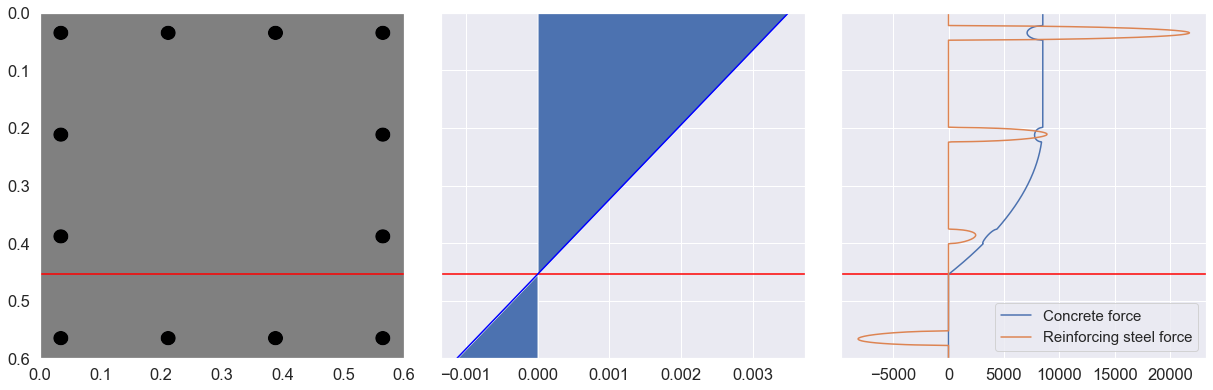

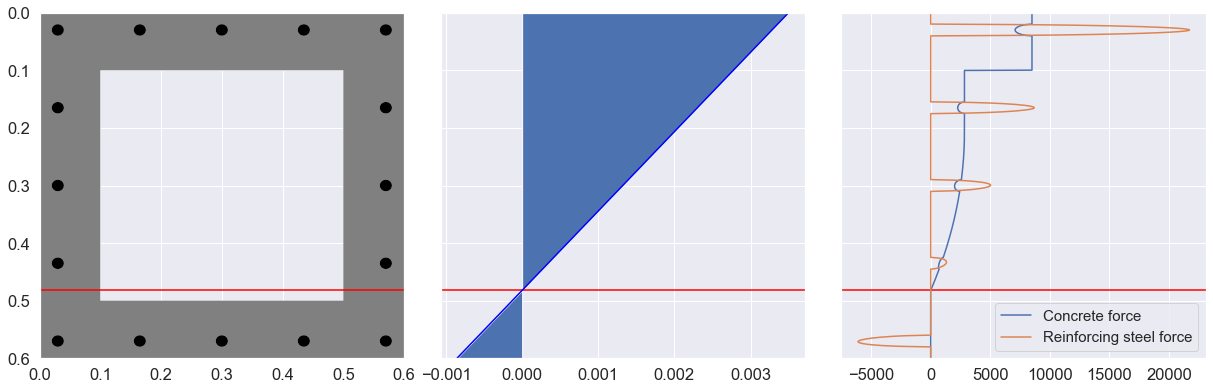

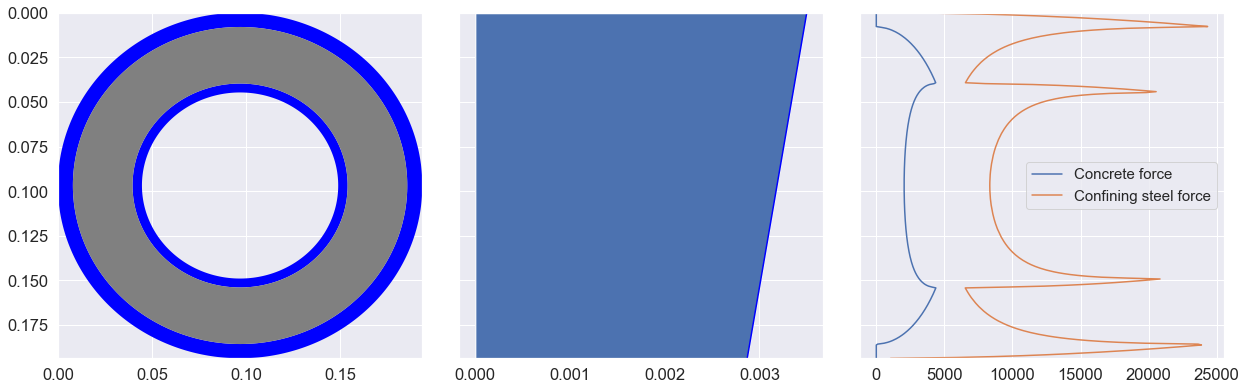

In [4]:
out = []
for title, both_sections in sections.items():
    section = both_sections['y']  # y and z sections should be the same, geometrically
    fig, axs = plt.subplots(1, 3, sharey=True, squeeze=True, figsize=(18, 6))
    # sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})

    axs[0].invert_yaxis()
    axs[0].set_ylim(0,section.height)
    axs[0].set_xlim(0,section.height)
    axs[0].invert_yaxis()

    slices = section.slices
    section.plot(axs[0])

    for ax in axs:
        ax.axhline(section.neutral_axis, color='red')

    axs[1].plot(
        slices.strain,
        slices.mid_height,
        color='blue'
    )

    axs[1].fill_betweenx(
        slices.mid_height,0,slices.strain,
    )


    axs[2].plot(
        slices.concrete_force,
        slices.mid_height,
        label = "Concrete force"
    )
    if section.conf_steel is not None:
        axs[2].plot(
            slices.conf_steel_force,
            slices.mid_height,
            label = "Confining steel force"
        )
    if section.reinf_steel is not None:
        axs[2].plot(
            slices.reinf_steel_force,
            slices.mid_height,
            label = "Reinforcing steel force"
        )
    axs[2].legend(fontsize=15)




    # axs[3].plot(
    #     slices.total_moment,
    #     slices.mid_height,
    #     label = "Total Moment"

    # )
    # axs[3].legend()

    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=1, 
                        top=0.9, 
                        wspace=0.1, 
                        hspace=0.3)
    # [ax.set_aspect('equal') for ax in axs.ravel()]

    # sns.set(font_scale = 1)

    plt.savefig(os.path.join('section_cases_results', title+"_section.svg"), format="svg")

In [5]:
cases_results

,Factor_ay,Slenderness Unconfined [-]y,Limit Slenderness Unconfined [-]y,Design Force Plastic [N]y,First Order Moment [Nm] My,Second Order Moment [Nm] My,Design Moment [Nm] My,Total Concrete Area [m2],Total Reinforcing Steel Area [m2],Total Confining Steel Area [m2],...,"Ratio of buckling and applied load, , [-] if less than 10 2nd order effect needs to be consideredy",e/dy,eta_ay,eta_cy,Relative Slenderness [-]z,Eccentricity over depth [-]z,"Ratio of buckling and applied load, , [-] if less than 10 2nd order effect needs to be consideredz",e/dz,eta_az,eta_cz
Title,,,,,,,,,,,,,,,,,,,,,
600x600_Level_00_Rectangular_Nmax_4H25,1.204537,26.340570,65.168684,1.259034e+07,26728.0,159472.543218,186200.543218,0.354119,0.005881,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600x600_Level_01_HollowRectangular_Mzmax_0.1_5H20,1.203727,17.075614,51.171584,7.706423e+06,2732.0,106964.641957,109696.641957,0.194982,0.005018,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600x600_Level_00_HollowCircular_Nmax_0.1937_0.008_0.1143_0.005,NaN,NaN,NaN,5.224595e+06,55680.0,109360.400000,165040.400000,0.014539,0.000000,0.006384,...,0.310858,0.040304,1.806076,2.580413,0.900429,0.060195,0.411707,0.060195,2.203903,0.806126


0.0 681529.3625198295
2000000.0 1038296.2665947385
4000000.0 1190893.0518724595
6000000.0 1117683.682156284
8000000.0 906791.6903448132
10000000.0 570791.1545898627
12000000.0 144147.822077411


c:\users\antig\pycharmprojects\sectionanalysis\venv\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
c:\users\antig\pycharmprojects\sectionanalysis\venv\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


0.0 590539.135009186
2000000.0 917889.5647322917
4000000.0 787293.2623856111
6000000.0 401606.19877556735
0.0 -0.011265025328611955


c:\users\antig\pycharmprojects\sectionanalysis\venv\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
c:\users\antig\pycharmprojects\sectionanalysis\venv\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
c:\users\antig\pycharmprojects\sectionanalysis\venv\lib\site-packages\scipy\optimize\_zeros_py.py:348: RuntimeWarning: Tolerance of 9.484364000438948 reached.
  warnings.warn(msg, RuntimeWarning)


2000000.0 171157.18238965608
4000000.0 69580.95529762987


c:\users\antig\pycharmprojects\sectionanalysis\venv\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
c:\users\antig\pycharmprojects\sectionanalysis\venv\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


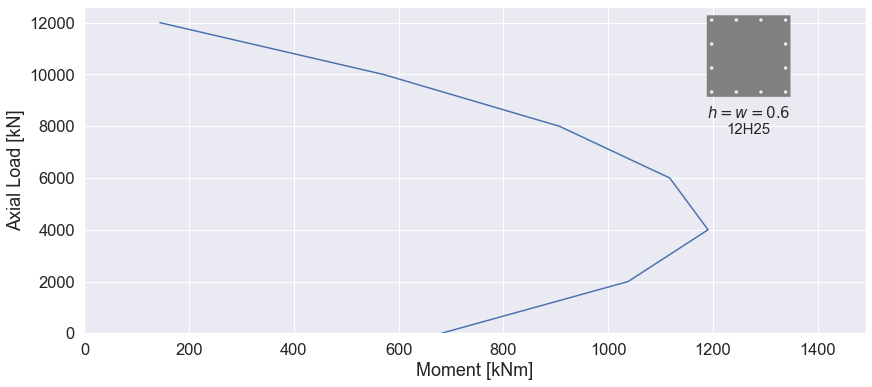

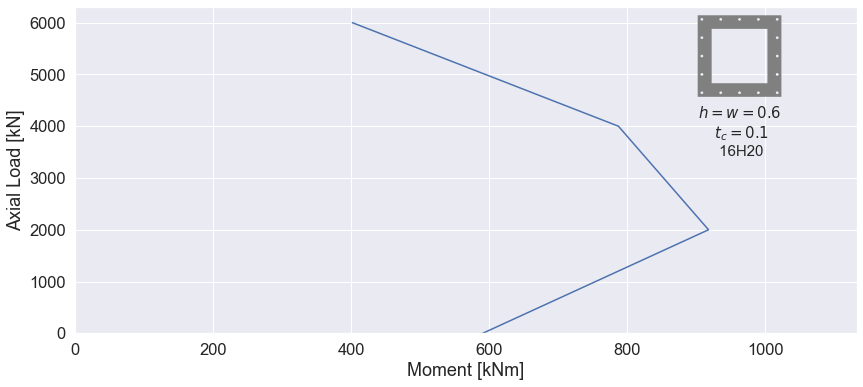

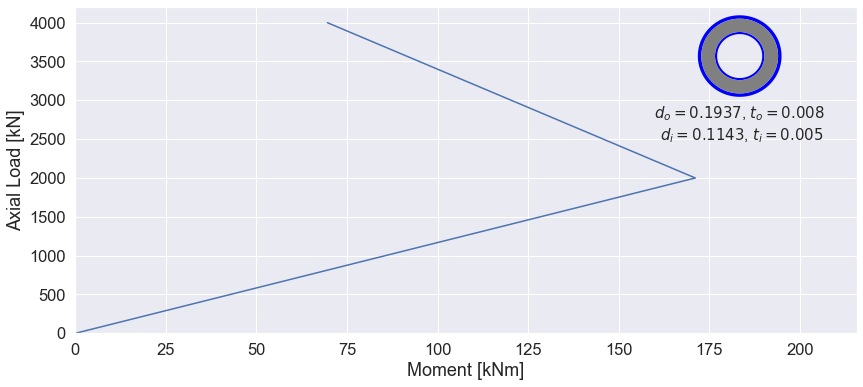

In [18]:
out = []
for title, both_sections in sections.items():
    section = both_sections['y']
    #design_moment = section.slices.concrete_area.sum() * section.concrete.design_strength + section.slices.reinf_steel_area.sum() * section.reinf_steel.characteristic_strength/1.15 + section.slices.conf_steel_area.sum() * section.conf_steel.characteristic_strength

    case = cases.loc[title]
    axial_loads = np.arange(0, cases_results.loc[title]['Design Force Plastic [N]z']+100e3, 2000e3)
    out = []
    legend = f"" #{case['Section shape']}, "
    if case['Section shape'] == 'Rectangular':
        legend +=f"$h=w={case['Height']:.1f}$\n" \
                 f"{case['number of reinf total']:.0f}H{case['Rebar Diameter']:.0f}"
    elif case['Section shape'] == 'HollowRectangular':
        legend +=f"$h=w={case['Height']:.1f}$\n $t_c={case['concrete thickness']}$\n {case['number of reinf total']:.0f}H{case['Rebar Diameter']:.0f}"
    elif case['Section shape'] == 'HollowCircular':
        legend +=f"$d_o={case['Outer steel diameter']}$, $t_o={case['Outer steel thickness']}$\n $d_i={case['Inner steel diameter']}$, $t_i={case['Inner steel thickness']}$"
    else:
        raise RuntimeError("Not supported section!")
    for axial_load in axial_loads:
        section.calculate_neutral_axis(axial_load, case['Outer steel thickness'] if case['Confinement'] else 0.0) # TODO
        total_moment = section.slices.total_moment.sum()
        print(axial_load, total_moment)
        out.append({'axial_load': axial_load, 'total_moment': total_moment})
    interaction_table = pd.DataFrame(out)
    interaction_table_kn = interaction_table / 1e3
    figsize=(14, 6)
    fig, ax = plt.subplots(1, 1, squeeze=True, figsize=figsize)
    sns.lineplot(
        data = interaction_table_kn,
        y = 'axial_load',
        x = 'total_moment',
        sort=False,
        ax=ax
    )
    ax.set_xlabel("Moment [kNm]")
    ax.set_ylabel("Axial Load [kN]")
    ax.set_ylim([0, None])
    ax.set_xlim([0, ax.get_xlim()[1] * 1.2])
    scale = 1.5 / section.height
    offset = (ax.get_xlim()[1] * 0.85, ax.get_ylim()[1]*0.7)

    # TODO Fix reinforcement properly
    section.polygons = { material: polygon
                         for material, polygon in section.polygons.items()
                         if section.reinf_steel is None or material != section.reinf_steel }

    section.plot(ax, offset=(offset[0], offset[1]+ax.get_ylim()[1]*0.15), scale=(scale * ax.get_xlim()[1] / figsize[0], scale * ax.get_ylim()[1] / figsize[1]))
    ax.text(offset[0], offset[1], f"{legend}", verticalalignment='top', horizontalalignment='center', fontsize='small')
    fig.savefig(os.path.join('M_N_cases_results', title+"_N_M.svg"), format="svg")

c:\users\antig\pycharmprojects\sectionanalysis\venv\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
c:\users\antig\pycharmprojects\sectionanalysis\venv\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


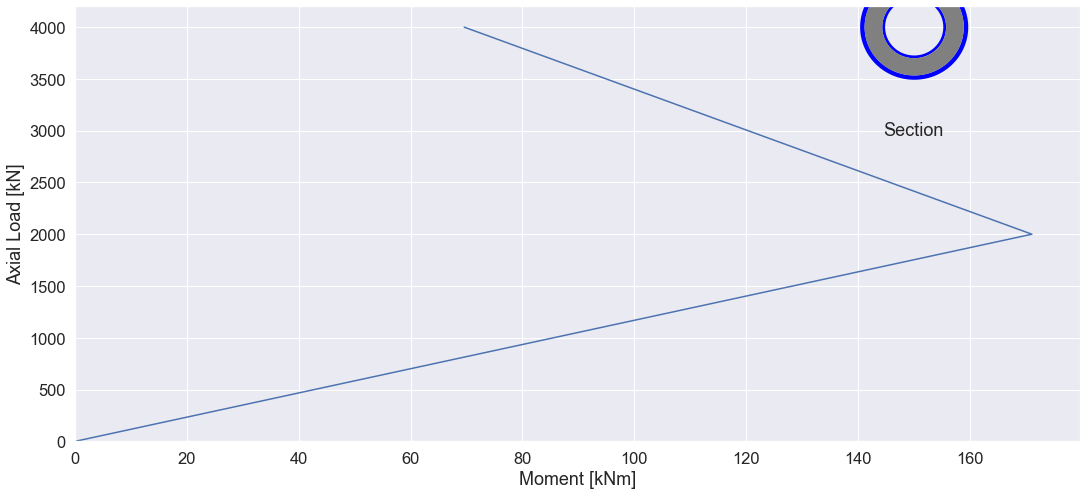

In [7]:
figsize=(18, 8)
fig, ax = plt.subplots(1, 1, squeeze=True, figsize=figsize)
sns.lineplot(
    data = interaction_table_kn,
    y = 'axial_load',
    x = 'total_moment',
    sort=False,
    ax=ax
)
ax.set_xlabel("Moment [kNm]")
ax.set_ylabel("Axial Load [kN]")
ax.set_ylim([0, None])
ax.set_xlim([0, None])

scale = 10.0
section.plot(ax, offset=(150, 4000), scale=(scale * ax.get_xlim()[1] / figsize[0], scale * ax.get_ylim()[1] / figsize[1]))
ax.text(150, 3000, "Section", verticalalignment='center', horizontalalignment='center',)
plt.show()